## Librerias

In [ ]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import os
import glob
os.environ["KERAS_BACKEND"] = "tensorflow"

import PIL
from PIL import Image

import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import ops
from keras import layers
import tensorflow.keras.backend as K
from scipy.stats import norm
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

## Imagenes

In [ ]:
!kaggle datasets download -d therealcyberlord/50k-celeba-dataset-64x64
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: 50k/146694.jpg          
  inflating: 50k/146704.jpg          
  inflating: 50k/146709.jpg          
  inflating: 50k/146710.jpg          
  inflating: 50k/146711.jpg          
  inflating: 50k/146714.jpg          
  inflating: 50k/146716.jpg          
  inflating: 50k/146717.jpg          
  inflating: 50k/146718.jpg          
  inflating: 50k/146722.jpg          
  inflating: 50k/146724.jpg          
  inflating: 50k/146728.jpg          
  inflating: 50k/146729.jpg          
  inflating: 50k/146730.jpg          
  inflating: 50k/146732.jpg          
  inflating: 50k/146736.jpg          
  inflating: 50k/146738.jpg          
  inflating: 50k/146747.jpg          
  inflating: 50k/146755.jpg          
  inflating: 50k/146761.jpg          
  inflating: 50k/146762.jpg          
  inflating: 50k/146768.jpg          
  inflating: 50k/146769.jpg          
  inflating: 50k/146777.jpg          
  inflating: 50k/146783.jpg          

In [ ]:
image_list = glob.glob(os.path.join('50k', '*.jpg'))

train = []; valid = []; test = []
for i in range(40000):
  image = Image.open(image_list[i])
  train.append(asarray(image))

for i in range(40000,45000):
  image = Image.open(image_list[i])
  valid.append(asarray(image))

  image = Image.open(image_list[i+5000])
  test.append(asarray(image))

train = np.array(train).astype("float32") / 255.0
valid = np.array(valid).astype("float32") / 255.0
test = np.array(test).astype("float32") / 255.0
print(test.shape)

(5000, 64, 64, 3)


## VAE

In [ ]:
#Sampling Layer

class Sampling(layers.Layer):
  #We create a new layer by subclassing the keras base Layer
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder

image_size = 64
embed_dim = 200
encoder_input = layers.Input(
    shape=(image_size, image_size, 3), name="encoder_input"
)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (4, 4), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!
x = layers.Flatten()(x)

#Instead of connecting the Flatten layer directly to the 2D latent space,
#we will connect it to layers z_mean and z_log_var.
z_mean = layers.Dense(embed_dim, name="z_mean")(x)
z_log_var = layers.Dense(embed_dim, name="z_log_var")(x)

#The Sampling layer samples a point z in the latent space from the
#normal distribution defined by the parameters z_mean and z_log_var.
z = Sampling()([z_mean, z_log_var])

#The Keras Model that defines the encoder—a model that takes an input
#image and outputs z_mean, z_log_var and a sampled point z from the
#normal distribution defined by these parameters.
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │          1,568 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         32,832 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 128)      │        131,200 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8192)           │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 200)            │      1,638,600 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 200)            │      1,638,600 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 200)            │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,442,800 (13.13 MB)

 Trainable params: 3,442,800 (13.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Decoder
decoder_input = layers.Input(shape=(embed_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(
    64, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(
    32, (4, 4), strides=2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(
    3,
    (4, 4),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8192)                │       1,646,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 32)          │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 64, 64, 3)           │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,074,339 (7.91 MB)

 Trainable params: 2,074,339 (7.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            #TensorFlow's Gradient Tape helps calculate gradients during a forward pass.
            #To use it, we need wrap the code that performs the operations you want to differentiate within a tf.GradientTape() context.
            #After recording the operations, we can compute the gradient of the loss function concerning certain variables using tape.gradient().
            #These gradients are then used to update the variables with the optimizer.

            z_mean, z_log_var, reconstruction = self(data)
            beta = 500
            reconstruction_loss = tf.reduce_mean(
                beta
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        beta = 500
        reconstruction_loss = tf.reduce_mean(
            beta
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
vae = VAE(encoder, decoder)

# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=optimizer)

vae.fit(
    train,
    epochs=250,
    batch_size=40,
    shuffle=True,
    validation_data=valid)
vae.save('vae4.keras')

# vae = keras.models.load_model('vae2.keras')
# os.path.isfile('vae2.keras')

Epoch 1/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - kl_loss: 7.3634 - reconstruction_loss: 303.8123 - total_loss: 311.1759 - val_kl_loss: 10.5688 - val_loss: 297.0591 - val_reconstruction_loss: 286.4903
Epoch 2/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - kl_loss: 9.9178 - reconstruction_loss: 284.3045 - total_loss: 294.2224 - val_kl_loss: 10.1392 - val_loss: 289.3277 - val_reconstruction_loss: 279.1885
Epoch 3/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - kl_loss: 9.8338 - reconstruction_loss: 280.5113 - total_loss: 290.3451 - val_kl_loss: 10.4118 - val_loss: 288.0558 - val_reconstruction_loss: 277.6440
Epoch 4/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - kl_loss: 9.9978 - reconstruction_loss: 280.1024 - total_loss: 290.1002 - val_kl_loss: 10.0945 - val_loss: 288.0975 - val_reconstruction_loss: 278.0030
Epoch 5/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - kl_loss: 10.1642 - reconstruction_loss: 279.4840 - total_loss: 289.6481 - val_kl_loss: 10.4475 - val_

In [ ]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


517


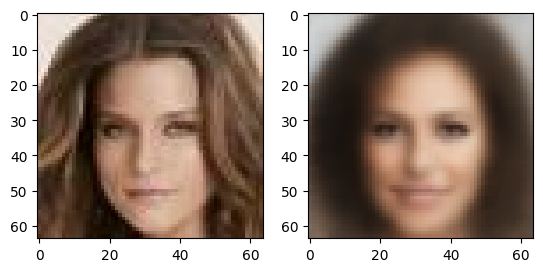

In [ ]:
import random
fig, ax = plt.subplots(1,2)
idx = random.randint(0,1000)
print(idx)
ax[0].imshow(test[idx])
ax[1].imshow(reconstructions[idx])

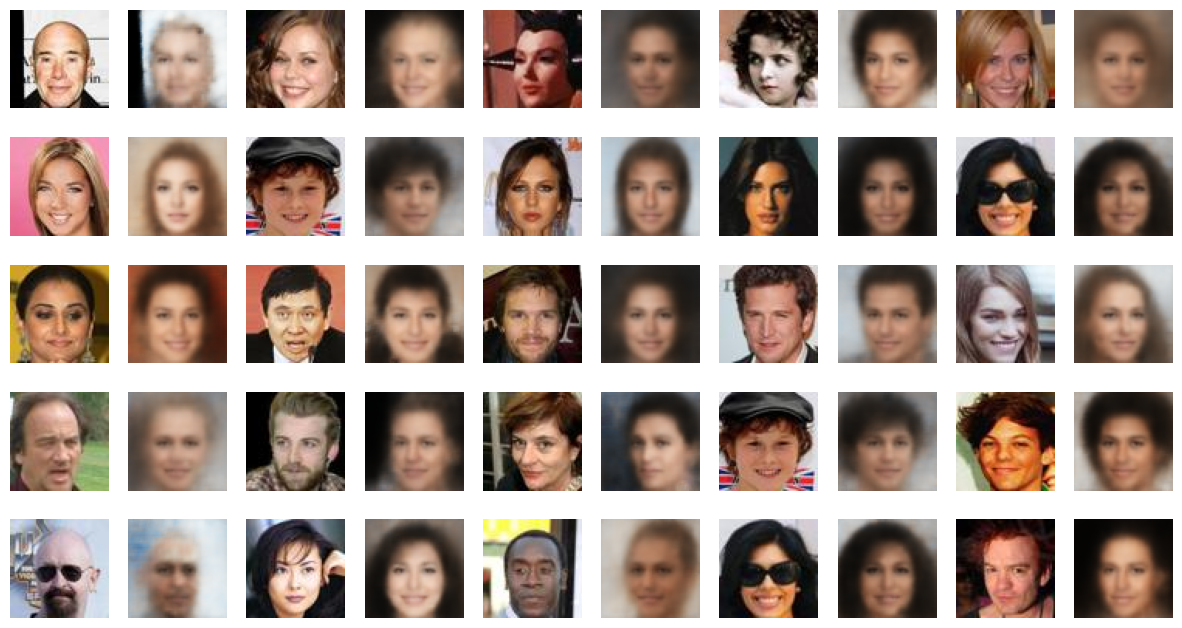

In [ ]:
import random

num_rows = 5
num_cols = int(10 / 2)

fig, ax = plt.subplots(num_rows, 2 * num_cols, figsize = (15,8))

for i in range(num_rows):
  for j in range(num_cols):
    idx = random.randint(0,1000)
    input_image = test[idx] # Original.
    faked_image = reconstructions[idx] #fake
    ax[i][j*2].imshow(input_image)
    ax[i][j*2+1].imshow(faked_image)
    ax[i][j*2].axis('off')
    ax[i][j*2+1].axis('off')

plt.show()

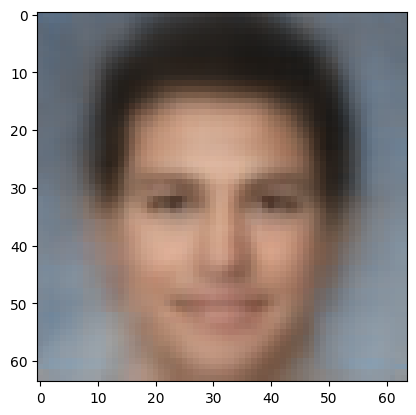

In [ ]:
z = np.expand_dims(np.random.normal(size = 200), axis=0)
faked_image = vae.decoder(z).numpy()[0]
plt.imshow(faked_image)

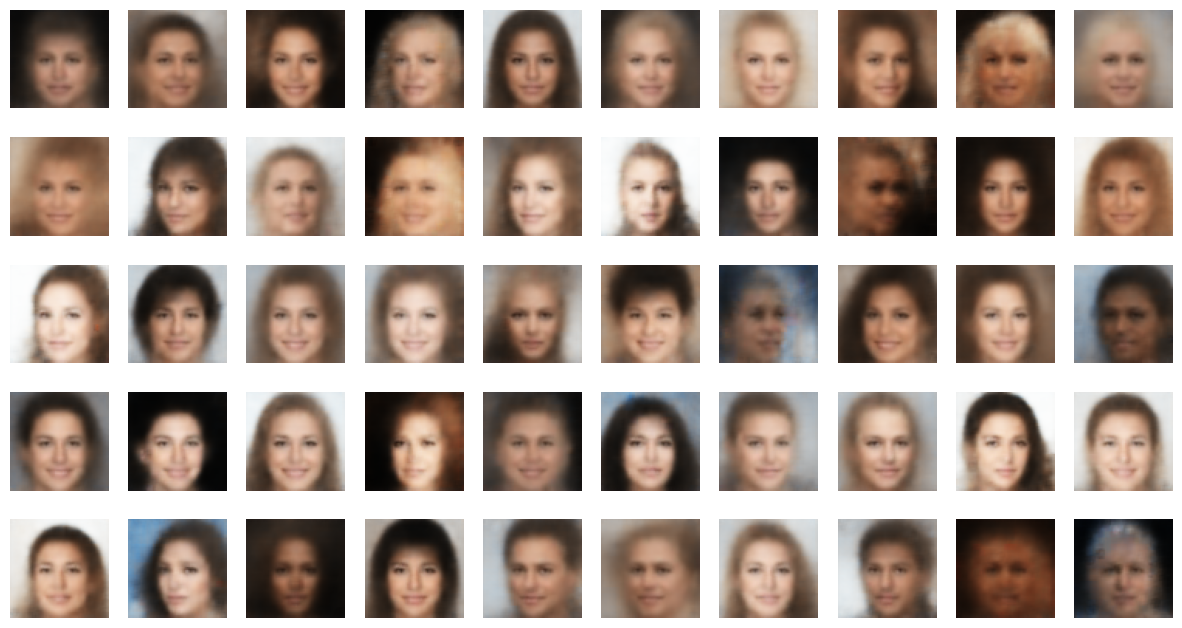

In [ ]:
fig, ax = plt.subplots(5,10, figsize=(15,8))

for i in range(5):
  for j in range(10):
    z = np.expand_dims(np.random.normal(size = 200), axis=0)
    faked_image = vae.decoder(z).numpy()[0]
    ax[i][j].imshow(faked_image)
    ax[i][j].axis('off')

plt.show()

In [ ]:
import pandas as pd
list_attr = pd.read_csv("list_attr_celeba.csv")

indx = np.array([int(name[4:10])-1 for name in image_list])
list_attr = list_attr.iloc[indx]

def get_feature_direction(VAE, list_attr, feature):
# Get the vector in the latent space that points in the direction of a particular feature.

  with_feature = list_attr[list_attr[feature] == 1]
  with_feature_index_list = np.array([int(name[0:6]) for name in with_feature['image_id'].to_numpy()])

  wout_feature = list_attr[list_attr[feature] == -1]
  wout_feature_index_list = np.array([int(name[0:6]) for name in wout_feature['image_id'].to_numpy()])

  cutoff = min(1000, len(with_feature_index_list), len(wout_feature_index_list))

  With_Feature = []
  for idx in with_feature_index_list[:cutoff]:
    s = str(idx)
    while len(s) < 6: s = '0'+s
    enc = VAE.encoder(np.expand_dims(asarray(Image.open('50k/'+s+'.jpg')).astype("float32")/255.0, axis = 0))
    With_Feature.append(asarray(enc).reshape(3,200))
  With_Feature = np.array(With_Feature)

  Wout_Feature = []
  for idx in wout_feature_index_list[:cutoff]:
    s = str(idx)
    while len(s) < 6: s = '0'+s
    enc = VAE.encoder(np.expand_dims(asarray(Image.open('50k/'+s+'.jpg')).astype("float32")/255.0, axis = 0))
    Wout_Feature.append(asarray(enc).reshape(3,200))
  Wout_Feature = np.array(Wout_Feature)

  With_Feature = np.mean(With_Feature, axis = 0)
  Wout_Feature = np.mean(Wout_Feature, axis = 0)

  return With_Feature - Wout_Feature

In [ ]:
NUM_SUBPLOTS = 11
feature = 'Blond_Hair'

# Get the vector that points in the direction of 'feature':
feature_delta = get_feature_direction(vae, list_attr, feature)

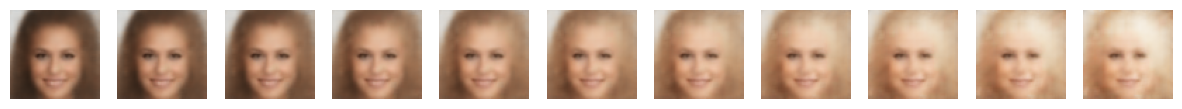

In [ ]:
plt.subplots(1, NUM_SUBPLOTS, figsize = (15, 15))

# Encode the original face:
wout_feature_sample = vae.encoder(np.expand_dims(test[517], axis = 0))

for i in range(NUM_SUBPLOTS):
# Add increasing multiplies of 'feature_delta' to superimpose 'feature' onto the original image:
  with_feature_sample = asarray(wout_feature_sample).reshape(3,200) + feature_delta * (3 * i / (NUM_SUBPLOTS - 1))

  # print(with_feature_sample[2])
  plt.subplot(1, NUM_SUBPLOTS, i + 1)
  z = np.expand_dims(with_feature_sample[2], axis=0)
  plt.imshow(vae.decoder(z).numpy()[0])
  plt.axis('off')

plt.show()